In [ ]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("CUDA is available!")
    print("GPU Device Count:", torch.cuda.device_count())
    print("Current GPU Device:", torch.cuda.current_device())
    print("GPU Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is NOT available. Running on CPU.")

# --- Add LRA CIFAR-10 config folder to sys.path ---
lra_cifar_path = "C:/Users/thera/anaconda3/s4/long-range-arena/lra_benchmarks/image/configs/cifar10"
if lra_cifar_path not in sys.path:
    sys.path.append(lra_cifar_path)
print("LRA CIFAR-10 config path added:", lra_cifar_path)

# --- Configuration (from base_cifar10_config.py) ---
class Config:
    batch_size = 128
    learning_rate = 0.0005
    num_epochs = 50  # Reduced for a quick proof-of-concept

config = Config()

# Dataset: CIFAR-10 with RGB kept as a sequence
# Each CIFAR-10 image is 3x32x32, flattened to a sequence of 3072 tokens.
transform_rgb = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to a 3072-length vector.
])

# Download and create the datasets
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_rgb)
test_dataset  = CIFAR10(root='./data', train=False, download=True, transform=transform_rgb)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=config.batch_size)

# Import S4D
try:
    from models.s4.s4d_new import S4D
except ImportError:
    raise ImportError("Not found")

# Update CIFARS4Model to allow passing a discretization technique parameter
class CIFARS4Model(nn.Module):
    def __init__(self, d_model=64, dropout=0.1, disc='zoh'):
        super().__init__()
        # Projection layer: maps each scalar (token) to a d_model vector.
        self.input_proj = nn.Linear(1, d_model)
        
        # S4 model: expects input in shape (B, L, d_model) if transposed=False.
        # Pass the discretization technique to S4D.
        self.s4_model = S4D(d_model=d_model, dropout=dropout, transposed=False, disc=disc)
        
        # Classifier: maps pooled S4 output to 10 classes (for CIFAR-10)
        self.classifier = nn.Linear(d_model, 10)
        
    def forward(self, x):
        # x shape: (batch, 3072)
        # Add a dimension so each token is a scalar (batch, 3072, 1)
        x = x.unsqueeze(-1)
        # Project each token from 1 -> d_model; new shape: (batch, 3072, d_model)
        x = self.input_proj(x)
        # Process through the S4 model; S4D expects input (B, L, d_model)
        x, _ = self.s4_model(x)
        # Pool across the sequence dimension (mean pooling here) to get (batch, d_model)
        x = x.mean(dim=1)
        # Final classification layer for CIFAR-10 (10 classes)
        logits = self.classifier(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of discretization techniques to evaluate
discretization_methods = ['zoh', 'bilinear', 'dirac', 'async']

# Dictionaries to store per-epoch training loss and test accuracy per discretization technique
all_epoch_train_losses = {}
all_epoch_test_accuracies = {}

# Training Setup for each discretization technique
for disc in discretization_methods:
    print(f"\nTraining with discretization: {disc}")
    model = CIFARS4Model(d_model=64, dropout=0.1, disc=disc)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    
    epoch_train_losses = []
    epoch_test_accuracies = []
    
    for epoch in range(config.num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        epoch_train_losses.append(avg_loss)
        
        # --- Evaluate on Test Set ---
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)
        test_acc = 100 * correct_test / total_test
        epoch_test_accuracies.append(test_acc)
        
        print(f"Disc: {disc}, Epoch [{epoch+1}/{config.num_epochs}] - Loss: {avg_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    all_epoch_train_losses[disc] = epoch_train_losses
    all_epoch_test_accuracies[disc] = epoch_test_accuracies



CUDA is available!
GPU Device Count: 1
Current GPU Device: 0
GPU Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
LRA CIFAR-10 config path added: C:/Users/thera/anaconda3/s4/long-range-arena/lra_benchmarks/image/configs/cifar10
Files already downloaded and verified
Files already downloaded and verified

Training with discretization: zoh
Disc: zoh, Epoch [1/50] - Loss: 2.2701, Test Acc: 16.68%
Disc: zoh, Epoch [2/50] - Loss: 2.1887, Test Acc: 23.52%
Disc: zoh, Epoch [3/50] - Loss: 2.0390, Test Acc: 28.83%
Disc: zoh, Epoch [4/50] - Loss: 1.9603, Test Acc: 30.62%
Disc: zoh, Epoch [5/50] - Loss: 1.9054, Test Acc: 32.08%
Disc: zoh, Epoch [6/50] - Loss: 1.8621, Test Acc: 34.04%
Disc: zoh, Epoch [7/50] - Loss: 1.8247, Test Acc: 35.06%
Disc: zoh, Epoch [8/50] - Loss: 1.7925, Test Acc: 36.29%
Disc: zoh, Epoch [9/50] - Loss: 1.7639, Test Acc: 37.14%
Disc: zoh, Epoch [10/50] - Loss: 1.7397, Test Acc: 38.15%
Disc: zoh, Epoch [11/50] - Loss: 1.7237, Test Acc: 38.62%
Disc: zoh, Epoch [12/50] - Los

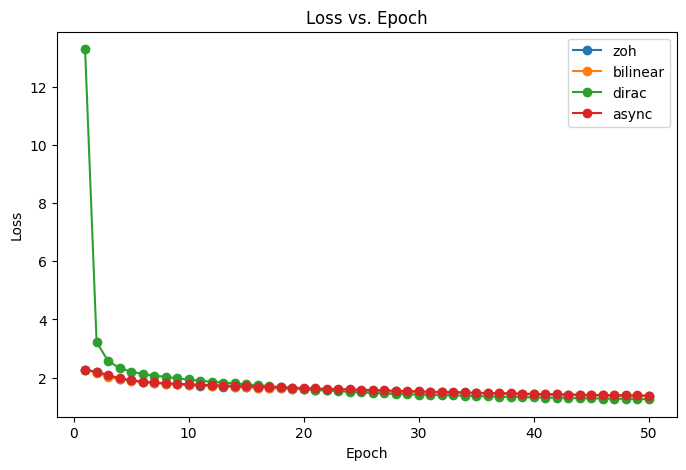

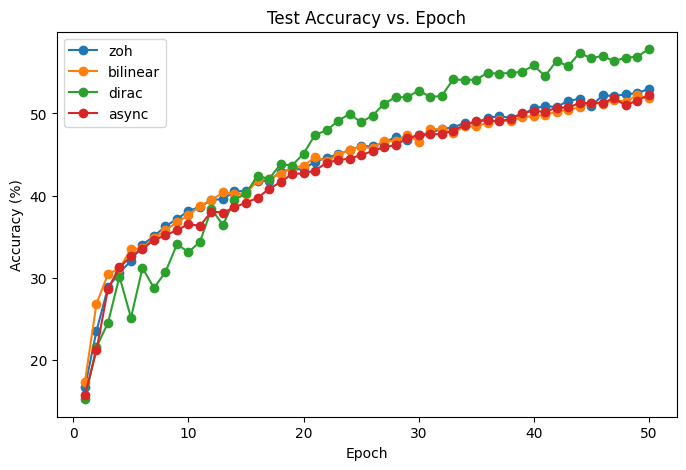

In [ ]:
# Plot Loss vs. Epoch for all discretization techniques 
plt.figure(figsize=(8,5))
for disc in discretization_methods:
    plt.plot(range(1, config.num_epochs+1), all_epoch_train_losses[disc], marker="o", linestyle="-", label=f"{disc}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()

# Plot Test Accuracy vs. Epoch for all discretization techniques 
plt.figure(figsize=(8,5))
for disc in discretization_methods:
    plt.plot(range(1, config.num_epochs+1), all_epoch_test_accuracies[disc], marker="o", linestyle="-", label=f"{disc}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy vs. Epoch")
plt.legend()
plt.show()
